In [1]:
import numpy as np 
import pandas as pd 
#import pydicom
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from efficientnet_pytorch import EfficientNet

In [2]:
# upload train dataframe
train_df_allsamples = pd.read_csv("../TrainTestDataFrames/marking.csv")
train_df_allsamples.head()

,patient_id,image_id,target,source,sex,age_approx,anatom_site_general_challenge
0,IP_7279968,ISIC_2637011,0,ISIC20,male,45.0,head/neck
1,IP_3075186,ISIC_0015719,0,ISIC20,female,45.0,upper extremity
2,IP_2842074,ISIC_0052212,0,ISIC20,female,50.0,lower extremity
3,IP_6890425,ISIC_0068279,0,ISIC20,female,45.0,head/neck
4,IP_8723313,ISIC_0074268,0,ISIC20,female,55.0,upper extremity


In [3]:
# load train and val dataframes
train_df = pd.read_csv("ENET_train_df_all.csv")
val_df = pd.read_csv("ENET_val_df_all.csv")

n_train = train_df.shape[0]
n_val = val_df.shape[0]

# create dictionary that maps image name to target 
image_names = val_df["image_id"].values 
val_targets = val_df["target"].values

percent_tp = sum(val_targets)/len(val_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])

print("{} Training and {} Validation samples".format(n_train, n_val))
print("{:.3f} percent of validation data set is a positive.".format(percent_tp))
print("Baseline validation accuracy is {:.3f}".format(baseline))

54438 Training and 6049 Validation samples
8.944 percent of validation data set is a positive.
Baseline validation accuracy is 91.056


In [4]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [5]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

'''
Training done in rounds, need different transforms in each round. 

round 1: Slight addition of noise 
round 2: More noise 
round 3: More noise

'''

# define a unique transform each time a positive is resampled: 

# basic transform
transform_1 = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# horizontal or vertical flip
transform_2 = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=(0.8, 1.2)),
    #transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# define transform with more noise for round 2
transform_round_2 = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.2), ratio=(0.7, 1.3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# no flip or rotation for test/validation data
transform_valid = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

def make_weights_for_balanced_classes(df, nclasses=2):   
    targets = df["target"].values
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[label] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[label]   
        
    return np.array(weight)  

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

# round 1 data loader 
class MyDataLoader_1():
    def __init__(self, df, path, batchsize, min_balance=None):
        # store df, path, weights, ...
        self.df = df 
        self.path = path
        self.w = make_weights_for_balanced_classes(df)
        self.batchsize = batchsize 
        self.balanced = True
        self.min_balance = min_balance
        
        # create a dictionary to map image_ids to index and target in dataframe 
        image_ids = self.df['image_id'].values 
        self.targets = self.df['target'].values
        inds = np.arange(len(image_ids))
        self.imgID2Idx = {im_id:ind for (im_id, ind) in zip(image_ids, inds)}
        self.imgID2Target = {im_id:target for (im_id, target) in zip(image_ids, self.targets)}
        
        # keep track of how many times samples have been drawn 
        self.counts = np.zeros(len(image_ids))
        
    def get_batch(self):
        # get image ids for the batch 
        if np.sum(self.w > 0) >= self.batchsize:
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        else:
            # update batchsize 
            print("Updating batchsize, maximum dataset size reached")
            self.batchsize = np.sum(self.w > 0)
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        
        # get the index locations for the image ids 
        batch_sample_inds = [self.imgID2Idx[im_id] for im_id in batch_image_ids]
        batch_targets = [self.imgID2Target[im_id] for im_id in batch_image_ids]
        
        # Update counts 
        self.counts[batch_sample_inds] += 1
        
        # Update sampling weights so that target=0 --> w = 0, target=1 --> w /= 2 
        for ind, target in zip(batch_sample_inds, batch_targets):
            # if the sample is a negative, then we don't want to sample it again 
            # if the sample has already been sampled 2 times, it shouldn't be sampled again
            # if target is positive, sampling should happen less frequently 
            if target == 0 or self.counts[ind] == 2:
                self.w[ind] = 0 
            else:
                self.w[ind] /= 2 
        
        # Data returned in shape [Batchsize, Channels, H, W]
        images = np.zeros((self.batchsize, 3, 256, 256)) 
        labels = np.zeros(self.batchsize)
        #meta_data = np.zeros((self.batchsize, 3))
        
        for i, index in enumerate(batch_sample_inds):
            
            # 1. load image
            img_name = self.df['image_id'].values[index]
            img_path = self.path + img_name + ".jpg"
            img = plt.imread(img_path)

            # 2. Preprocess the data (e.g. torchvision.Transform).
            img = Image.fromarray(img)
            if self.counts[index] == 1:
                images[i, :, :, :] = transform_1_round1(img)
            if self.counts[index] == 2:
                images[i, :, :, :] = transform_2_round1(img)
            
            # 3. store label 
            labels[i] = self.imgID2Target[img_name]
                
        # Quit once all positive samples have zero valued weights 
        if np.sum(self.w[self.targets==1]) == 0:
            self.balanced = False
            
        # If a min balance is specified, quit at min balance
        if self.min_balance:
            if sum(labels)/len(labels) <= self.min_balance:
                self.balanced = False
        
        # return data 
        X = torch.tensor(images, dtype = torch.float32)
        y = torch.tensor(labels, dtype = torch.float32)
        return X, y #, meta_data
    
# round 2 data loader 
class MyDataLoader_2():
    def __init__(self, df, path, batchsize, min_balance=None):
        # store df, path, weights, ...
        self.df = df 
        self.path = path
        self.w = make_weights_for_balanced_classes(df)
        self.batchsize = batchsize 
        self.balanced = True
        self.min_balance = min_balance
        
        # create a dictionary to map image_ids to index and target in dataframe 
        image_ids = self.df['image_id'].values 
        self.targets = self.df['target'].values
        inds = np.arange(len(image_ids))
        self.imgID2Idx = {im_id:ind for (im_id, ind) in zip(image_ids, inds)}
        self.imgID2Target = {im_id:target for (im_id, target) in zip(image_ids, self.targets)}
        
        # keep track of how many times samples have been drawn 
        self.counts = np.zeros(len(image_ids))
        
    def get_batch(self):
        # get image ids for the batch 
        if np.sum(self.w > 0) >= self.batchsize:
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        else:
            # update batchsize 
            print("Updating batchsize, maximum dataset size reached")
            self.batchsize = np.sum(self.w > 0)
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        
        # get the index locations for the image ids 
        batch_sample_inds = [self.imgID2Idx[im_id] for im_id in batch_image_ids]
        batch_targets = [self.imgID2Target[im_id] for im_id in batch_image_ids]
        
        # Update counts 
        self.counts[batch_sample_inds] += 1
        
        # Update sampling weights so that target=0 --> w = 0, target=1 --> w /= 2 
        for ind, target in zip(batch_sample_inds, batch_targets):
            # if the sample is a negative, then we don't want to sample it again 
            # if the sample has already been sampled 2 times, it shouldn't be sampled again
            # if target is positive, sampling should happen less frequently 
            if target == 0 or self.counts[ind] == 2:
                self.w[ind] = 0 
            else:
                self.w[ind] /= 2 
        
        # Data returned in shape [Batchsize, Channels, H, W]
        images = np.zeros((self.batchsize, 3, 256, 256)) 
        labels = np.zeros(self.batchsize)
        #meta_data = np.zeros((self.batchsize, 3))
        
        for i, index in enumerate(batch_sample_inds):
            
            # 1. load image
            img_name = self.df['image_id'].values[index]
            img_path = self.path + img_name + ".jpg"
            img = plt.imread(img_path)

            # 2. Preprocess the data (e.g. torchvision.Transform).
            img = Image.fromarray(img)
            if self.counts[index] == 1:
                images[i, :, :, :] = transform_1_round2(img)
            if self.counts[index] == 2:
                images[i, :, :, :] = transform_2_round2(img)
            
            # 3. store label 
            labels[i] = self.imgID2Target[img_name]
                
        # Quit once all positive samples have zero valued weights 
        if np.sum(self.w[self.targets==1]) == 0:
            self.balanced = False
            
        # If a min balance is specified, quit at min balance
        if self.min_balance:
            if sum(labels)/len(labels) <= self.min_balance:
                self.balanced = False
        
        # return data 
        X = torch.tensor(images, dtype = torch.float32)
        y = torch.tensor(labels, dtype = torch.float32)
        return X, y #, meta_data

In [6]:
# First, load the EfficientNet with pre-trained parameters 
ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

Loaded pretrained weights for efficientnet-b0


In [7]:
# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, Net):
        super(MyENet, self).__init__()
        self.Net = Net
        self.output = nn.Sequential(
            nn.Linear(1000, 1),
            nn.Sigmoid())
        
    def embedding(self, x):
        out = self.Net(x)
        return out 
        
    def forward(self, x):
        out = self.Net(x)
        out = self.output(out)
        return out

model = MyENet(ENet).to(device)
model.load_state_dict(torch.load('../Models/ENETmodel_all.ckpt'))

<All keys matched successfully>

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, 
                patience=3, num_epochs=25):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# Train the model
# Use the prebuilt data loader.
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"
path_to_model = '../Models/ENETmodel_all_2.ckpt'

# evaluate performance on validation data 
valid_dataset = ValidDataset(val_df, path)                                              
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset) 

# save losses from training 
num_epochs = 30
batchsize  = 25

train_roc = []
val_roc   = []
losses    = []
patience     = 3
set_patience = 3 
best_val     = 0

# Loss and optimizer
criterion = nn.BCELoss()

### ROUND 2 ### 
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# scheduler reduces learning rate by factor of 10 when val auc does not improve
scheduler = ReduceLROnPlateau(optimizer=optimizer, min_lr=3e-6, mode='max', patience=0, verbose=True)


Round 2, Epoch [1/30], Balance 0.44, Loss: 0.2474, Train ROC AUC: 0.9610
Round 2, Epoch [1/30], Balance 0.48, Loss: 0.4907, Train ROC AUC: 0.9167
Round 2, Epoch [1/30], Balance 0.52, Loss: 0.2528, Train ROC AUC: 0.9679
Round 2, Epoch [1/30], Balance 0.68, Loss: 0.4907, Train ROC AUC: 0.8088
Round 2, Epoch [1/30], Balance 0.44, Loss: 0.2171, Train ROC AUC: 0.9740
Round 2, Epoch [1/30], Balance 0.48, Loss: 0.3890, Train ROC AUC: 0.9038
Round 2, Epoch [1/30], Balance 0.44, Loss: 0.9657, Train ROC AUC: 0.7338
Round 2, Epoch [1/30], Balance 0.40, Loss: 0.4972, Train ROC AUC: 0.8933
Round 2, Epoch [1/30], Balance 0.48, Loss: 0.2567, Train ROC AUC: 0.9615
Round 2, Epoch [1/30], Balance 0.44, Loss: 0.3679, Train ROC AUC: 0.9091
Round 2, Epoch [1/30], Balance 0.40, Loss: 0.3721, Train ROC AUC: 0.9067
Round 2, Epoch [1/30], Balance 0.52, Loss: 0.4882, Train ROC AUC: 0.8718
Round 2, Epoch [1/30], Balance 0.28, Loss: 0.5489, Train ROC AUC: 0.8254
Round 2, Epoch [1/30], Balance 0.60, Loss: 0.6116, 

Round 2, Epoch [2/30], Balance 0.48, Loss: 0.8543, Train ROC AUC: 0.7051
Round 2, Epoch [2/30], Balance 0.68, Loss: 0.3628, Train ROC AUC: 0.9706
Round 2, Epoch [2/30], Balance 0.56, Loss: 0.3732, Train ROC AUC: 0.9221
Round 2, Epoch [2/30], Balance 0.68, Loss: 0.3283, Train ROC AUC: 0.9632
Round 2, Epoch [2/30], Balance 0.44, Loss: 0.7209, Train ROC AUC: 0.6429
Round 2, Epoch [2/30], Balance 0.60, Loss: 0.3210, Train ROC AUC: 0.9667
Round 2, Epoch [2/30], Balance 0.52, Loss: 0.4925, Train ROC AUC: 0.8654
Round 2, Epoch [2/30], Balance 0.44, Loss: 0.6097, Train ROC AUC: 0.8571
Round 2, Epoch [2/30], Balance 0.44, Loss: 0.4018, Train ROC AUC: 0.9610
Round 2, Epoch [2/30], Balance 0.52, Loss: 0.3730, Train ROC AUC: 0.8846
Round 2, Epoch [2/30], Balance 0.44, Loss: 0.3863, Train ROC AUC: 0.9481
Round 2, Epoch [2/30], Balance 0.44, Loss: 0.4553, Train ROC AUC: 0.8831
Round 2, Epoch [2/30], Balance 0.52, Loss: 0.5333, Train ROC AUC: 0.8077
Round 2, Epoch [2/30], Balance 0.72, Loss: 0.8160, 

Round 2, Epoch [2/30], Balance 0.48, Loss: 0.5683, Train ROC AUC: 0.8462
Round 2, Epoch [2/30], Balance 0.64, Loss: 0.3882, Train ROC AUC: 0.9653
Round 2, Epoch [2/30], Balance 0.36, Loss: 0.5168, Train ROC AUC: 0.8333
Round 2, Epoch [2/30], Balance 0.36, Loss: 0.4365, Train ROC AUC: 0.8542
Round 2, Epoch [2/30], Balance 0.52, Loss: 0.3820, Train ROC AUC: 0.9551
Round 2, Epoch [2/30], Balance 0.52, Loss: 0.4673, Train ROC AUC: 0.8526
Round 2, Epoch [2/30], Balance 0.56, Loss: 0.6271, Train ROC AUC: 0.7532
Round 2, Epoch [2/30], Balance 0.32, Loss: 0.3335, Train ROC AUC: 0.9559
Round 2, Epoch [2/30], Balance 0.68, Loss: 0.5724, Train ROC AUC: 0.9485
Round 2, Epoch [2/30], Balance 0.52, Loss: 0.5018, Train ROC AUC: 0.8462
Round 2, Epoch [2/30], Balance 0.48, Loss: 0.3952, Train ROC AUC: 0.9038
Round 2, Epoch [2/30], Balance 0.52, Loss: 0.4443, Train ROC AUC: 0.8397
Round 2, Epoch [2/30], Balance 0.52, Loss: 0.3632, Train ROC AUC: 0.9103
Round 2, Epoch [2/30], Balance 0.32, Loss: 0.5411, 

Round 2, Epoch [3/30], Balance 0.40, Loss: 0.3543, Train ROC AUC: 0.9467
Round 2, Epoch [3/30], Balance 0.36, Loss: 0.3807, Train ROC AUC: 0.9028
Round 2, Epoch [3/30], Balance 0.48, Loss: 0.3872, Train ROC AUC: 0.9231
Round 2, Epoch [3/30], Balance 0.60, Loss: 0.5970, Train ROC AUC: 0.8267
Round 2, Epoch [3/30], Balance 0.28, Loss: 0.4751, Train ROC AUC: 0.8413
Round 2, Epoch [3/30], Balance 0.52, Loss: 0.3799, Train ROC AUC: 0.9295
Round 2, Epoch [3/30], Balance 0.44, Loss: 0.6118, Train ROC AUC: 0.7532
Round 2, Epoch [3/30], Balance 0.48, Loss: 0.4195, Train ROC AUC: 0.8526
Round 2, Epoch [3/30], Balance 0.52, Loss: 0.3330, Train ROC AUC: 0.9551
Round 2, Epoch [3/30], Balance 0.44, Loss: 0.5047, Train ROC AUC: 0.8377
Round 2, Epoch [3/30], Balance 0.44, Loss: 0.4124, Train ROC AUC: 0.8766
Round 2, Epoch [3/30], Balance 0.52, Loss: 0.2145, Train ROC AUC: 0.9872
Round 2, Epoch [3/30], Balance 0.60, Loss: 0.3208, Train ROC AUC: 0.9333
Round 2, Epoch [3/30], Balance 0.52, Loss: 0.4827, 

Round 2, Epoch [4/30], Balance 0.56, Loss: 0.6252, Train ROC AUC: 0.8636
Round 2, Epoch [4/30], Balance 0.64, Loss: 0.4616, Train ROC AUC: 0.9097
Round 2, Epoch [4/30], Balance 0.40, Loss: 0.4045, Train ROC AUC: 0.9200
Round 2, Epoch [4/30], Balance 0.44, Loss: 0.3485, Train ROC AUC: 0.9545
Round 2, Epoch [4/30], Balance 0.60, Loss: 0.2694, Train ROC AUC: 0.9667
Round 2, Epoch [4/30], Balance 0.48, Loss: 0.8188, Train ROC AUC: 0.6795
Round 2, Epoch [4/30], Balance 0.52, Loss: 0.3046, Train ROC AUC: 0.9551
Round 2, Epoch [4/30], Balance 0.40, Loss: 0.4284, Train ROC AUC: 0.8733
Round 2, Epoch [4/30], Balance 0.44, Loss: 0.4393, Train ROC AUC: 0.9286
Round 2, Epoch [4/30], Balance 0.48, Loss: 0.4712, Train ROC AUC: 0.8205
Round 2, Epoch [4/30], Balance 0.40, Loss: 0.3750, Train ROC AUC: 0.9400
Round 2, Epoch [4/30], Balance 0.48, Loss: 0.3327, Train ROC AUC: 0.9295
Round 2, Epoch [4/30], Balance 0.48, Loss: 0.2808, Train ROC AUC: 0.9808
Round 2, Epoch [4/30], Balance 0.40, Loss: 0.4588, 

Round 2, Epoch [5/30], Balance 0.56, Loss: 0.3815, Train ROC AUC: 0.8766
Round 2, Epoch [5/30], Balance 0.48, Loss: 0.2216, Train ROC AUC: 0.9872
Round 2, Epoch [5/30], Balance 0.32, Loss: 0.3709, Train ROC AUC: 0.9338
Round 2, Epoch [5/30], Balance 0.32, Loss: 0.5099, Train ROC AUC: 0.8162
Round 2, Epoch [5/30], Balance 0.48, Loss: 0.2962, Train ROC AUC: 0.9551
Round 2, Epoch [5/30], Balance 0.36, Loss: 0.4822, Train ROC AUC: 0.8611
Round 2, Epoch [5/30], Balance 0.60, Loss: 0.4813, Train ROC AUC: 0.8267
Round 2, Epoch [5/30], Balance 0.60, Loss: 0.4492, Train ROC AUC: 0.8733
Round 2, Epoch [5/30], Balance 0.56, Loss: 0.3677, Train ROC AUC: 0.9156
Round 2, Epoch [5/30], Balance 0.52, Loss: 0.5574, Train ROC AUC: 0.8205
Round 2, Epoch [5/30], Balance 0.44, Loss: 0.3347, Train ROC AUC: 0.9416
Round 2, Epoch [5/30], Balance 0.52, Loss: 0.2969, Train ROC AUC: 0.9808
Round 2, Epoch [5/30], Balance 0.40, Loss: 0.2967, Train ROC AUC: 0.9800
Round 2, Epoch [5/30], Balance 0.52, Loss: 0.3571, 

Round 2, Epoch [6/30], Balance 0.56, Loss: 0.2358, Train ROC AUC: 1.0000
Round 2, Epoch [6/30], Balance 0.36, Loss: 0.6060, Train ROC AUC: 0.7847
Round 2, Epoch [6/30], Balance 0.36, Loss: 0.4591, Train ROC AUC: 0.8750
Round 2, Epoch [6/30], Balance 0.60, Loss: 0.5395, Train ROC AUC: 0.8600
Round 2, Epoch [6/30], Balance 0.56, Loss: 0.5512, Train ROC AUC: 0.8377
Round 2, Epoch [6/30], Balance 0.36, Loss: 0.4759, Train ROC AUC: 0.8889
Round 2, Epoch [6/30], Balance 0.28, Loss: 0.3573, Train ROC AUC: 0.9841
Round 2, Epoch [6/30], Balance 0.28, Loss: 0.4108, Train ROC AUC: 0.9524
Round 2, Epoch [6/30], Balance 0.44, Loss: 0.2413, Train ROC AUC: 0.9935
Round 2, Epoch [6/30], Balance 0.56, Loss: 0.4691, Train ROC AUC: 0.8377
Round 2, Epoch [6/30], Balance 0.44, Loss: 0.2576, Train ROC AUC: 0.9740
Round 2, Epoch [6/30], Balance 0.84, Loss: 0.6795, Train ROC AUC: 0.8690
Round 2, Epoch [6/30], Balance 0.60, Loss: 0.3318, Train ROC AUC: 0.9600
Round 2, Epoch [6/30], Balance 0.48, Loss: 0.3655, 

Round 2, Epoch [7/30], Balance 0.48, Loss: 0.2950, Train ROC AUC: 0.9359
Round 2, Epoch [7/30], Balance 0.68, Loss: 0.3753, Train ROC AUC: 0.9412
Round 2, Epoch [7/30], Balance 0.40, Loss: 0.4416, Train ROC AUC: 0.8933
Round 2, Epoch [7/30], Balance 0.44, Loss: 0.4525, Train ROC AUC: 0.8571
Round 2, Epoch [7/30], Balance 0.56, Loss: 0.3312, Train ROC AUC: 0.9351
Round 2, Epoch [7/30], Balance 0.60, Loss: 0.3682, Train ROC AUC: 0.9067
Round 2, Epoch [7/30], Balance 0.40, Loss: 0.4057, Train ROC AUC: 0.9267
Round 2, Epoch [7/30], Balance 0.48, Loss: 0.3508, Train ROC AUC: 0.9231
Round 2, Epoch [7/30], Balance 0.56, Loss: 0.2480, Train ROC AUC: 0.9740
Round 2, Epoch [7/30], Balance 0.36, Loss: 0.6059, Train ROC AUC: 0.8403
Round 2, Epoch [7/30], Balance 0.36, Loss: 0.4543, Train ROC AUC: 0.9097
Round 2, Epoch [7/30], Balance 0.56, Loss: 0.5939, Train ROC AUC: 0.8247
Round 2, Epoch [7/30], Balance 0.32, Loss: 0.2938, Train ROC AUC: 0.9853
Round 2, Epoch [7/30], Balance 0.28, Loss: 0.5113, 

Round 2, Epoch [8/30], Balance 0.52, Loss: 0.5247, Train ROC AUC: 0.8013
Round 2, Epoch [8/30], Balance 0.48, Loss: 0.3600, Train ROC AUC: 0.9295
Round 2, Epoch [8/30], Balance 0.56, Loss: 0.4670, Train ROC AUC: 0.8701
Round 2, Epoch [8/30], Balance 0.40, Loss: 0.3322, Train ROC AUC: 0.9933
Round 2, Epoch [8/30], Balance 0.60, Loss: 0.5236, Train ROC AUC: 0.8667
Round 2, Epoch [8/30], Balance 0.48, Loss: 0.4328, Train ROC AUC: 0.8333
Round 2, Epoch [8/30], Balance 0.40, Loss: 0.3691, Train ROC AUC: 0.9267
Round 2, Epoch [8/30], Balance 0.52, Loss: 0.2773, Train ROC AUC: 0.9359
Round 2, Epoch [8/30], Balance 0.48, Loss: 0.3252, Train ROC AUC: 0.9423
Round 2, Epoch [8/30], Balance 0.56, Loss: 0.4573, Train ROC AUC: 0.8766
Round 2, Epoch [8/30], Balance 0.32, Loss: 0.3293, Train ROC AUC: 0.9412
Round 2, Epoch [8/30], Balance 0.36, Loss: 0.5981, Train ROC AUC: 0.8264
Round 2, Epoch [8/30], Balance 0.32, Loss: 0.3935, Train ROC AUC: 0.9559
Round 2, Epoch [8/30], Balance 0.32, Loss: 0.3236, 

Round 2, Epoch [9/30], Balance 0.56, Loss: 0.2947, Train ROC AUC: 0.9481
Round 2, Epoch [9/30], Balance 0.36, Loss: 0.3801, Train ROC AUC: 0.8889
Round 2, Epoch [9/30], Balance 0.64, Loss: 0.2277, Train ROC AUC: 1.0000
Round 2, Epoch [9/30], Balance 0.52, Loss: 0.8146, Train ROC AUC: 0.7500
Round 2, Epoch [9/30], Balance 0.40, Loss: 0.2823, Train ROC AUC: 0.9533
Round 2, Epoch [9/30], Balance 0.48, Loss: 0.4593, Train ROC AUC: 0.8846
Round 2, Epoch [9/30], Balance 0.36, Loss: 0.4402, Train ROC AUC: 0.9097
Round 2, Epoch [9/30], Balance 0.24, Loss: 0.4211, Train ROC AUC: 0.9474

Round 2, Epoch [9/30], Val ROC AUC: 0.9189

Round 2, Epoch [10/30], Balance 0.44, Loss: 0.4011, Train ROC AUC: 0.9026
Round 2, Epoch [10/30], Balance 0.44, Loss: 0.4685, Train ROC AUC: 0.8506
Round 2, Epoch [10/30], Balance 0.52, Loss: 0.2186, Train ROC AUC: 0.9808
Round 2, Epoch [10/30], Balance 0.48, Loss: 0.4047, Train ROC AUC: 0.8846
Round 2, Epoch [10/30], Balance 0.52, Loss: 0.4038, Train ROC AUC: 0.9038
R

Round 2, Epoch [10/30], Balance 0.44, Loss: 0.4616, Train ROC AUC: 0.8506
Round 2, Epoch [10/30], Balance 0.52, Loss: 0.2912, Train ROC AUC: 0.9615
Round 2, Epoch [10/30], Balance 0.52, Loss: 0.3964, Train ROC AUC: 0.9038
Round 2, Epoch [10/30], Balance 0.48, Loss: 0.2486, Train ROC AUC: 0.9423
Round 2, Epoch [10/30], Balance 0.52, Loss: 0.3391, Train ROC AUC: 0.9423
Round 2, Epoch [10/30], Balance 0.32, Loss: 0.3210, Train ROC AUC: 0.9559
Round 2, Epoch [10/30], Balance 0.36, Loss: 0.4815, Train ROC AUC: 0.8542
Round 2, Epoch [10/30], Balance 0.44, Loss: 0.3441, Train ROC AUC: 0.9351
Round 2, Epoch [10/30], Balance 0.56, Loss: 0.4854, Train ROC AUC: 0.8636
Round 2, Epoch [10/30], Balance 0.36, Loss: 0.4552, Train ROC AUC: 0.8889
Round 2, Epoch [10/30], Balance 0.56, Loss: 0.3540, Train ROC AUC: 0.9351
Round 2, Epoch [10/30], Balance 0.60, Loss: 0.2648, Train ROC AUC: 0.9867
Round 2, Epoch [10/30], Balance 0.32, Loss: 0.3940, Train ROC AUC: 0.9338
Round 2, Epoch [10/30], Balance 0.60, 

Round 2, Epoch [13/30], Balance 0.48, Loss: 0.2861, Train ROC AUC: 0.9487
Round 2, Epoch [13/30], Balance 0.56, Loss: 0.2238, Train ROC AUC: 0.9740
Round 2, Epoch [13/30], Balance 0.36, Loss: 0.3314, Train ROC AUC: 0.9444
Round 2, Epoch [13/30], Balance 0.60, Loss: 0.3581, Train ROC AUC: 0.9200
Round 2, Epoch [13/30], Balance 0.48, Loss: 0.2719, Train ROC AUC: 0.9679
Round 2, Epoch [13/30], Balance 0.52, Loss: 0.5153, Train ROC AUC: 0.8205
Round 2, Epoch [13/30], Balance 0.44, Loss: 0.3176, Train ROC AUC: 0.9416
Round 2, Epoch [13/30], Balance 0.48, Loss: 0.4926, Train ROC AUC: 0.8654
Round 2, Epoch [13/30], Balance 0.48, Loss: 0.2436, Train ROC AUC: 0.9679
Round 2, Epoch [13/30], Balance 0.48, Loss: 0.2075, Train ROC AUC: 0.9872
Round 2, Epoch [13/30], Balance 0.36, Loss: 0.5970, Train ROC AUC: 0.8403
Round 2, Epoch [13/30], Balance 0.36, Loss: 0.3221, Train ROC AUC: 0.9583
Round 2, Epoch [13/30], Balance 0.64, Loss: 0.1978, Train ROC AUC: 1.0000
Round 2, Epoch [13/30], Balance 0.32, 

Round 2, Epoch [13/30], Balance 0.40, Loss: 0.2839, Train ROC AUC: 0.9733
Round 2, Epoch [13/30], Balance 0.40, Loss: 0.2782, Train ROC AUC: 0.9600
Round 2, Epoch [13/30], Balance 0.48, Loss: 0.3666, Train ROC AUC: 0.9038
Round 2, Epoch [13/30], Balance 0.60, Loss: 0.3894, Train ROC AUC: 0.8800
Round 2, Epoch [13/30], Balance 0.64, Loss: 0.5426, Train ROC AUC: 0.8542
Round 2, Epoch [13/30], Balance 0.36, Loss: 0.4333, Train ROC AUC: 0.8958
Round 2, Epoch [13/30], Balance 0.44, Loss: 0.2362, Train ROC AUC: 0.9675
Round 2, Epoch [13/30], Balance 0.48, Loss: 0.3637, Train ROC AUC: 0.9359
Round 2, Epoch [13/30], Balance 0.36, Loss: 0.1507, Train ROC AUC: 1.0000
Round 2, Epoch [13/30], Balance 0.60, Loss: 0.3853, Train ROC AUC: 0.9133
Round 2, Epoch [13/30], Balance 0.40, Loss: 0.4747, Train ROC AUC: 0.8667
Round 2, Epoch [13/30], Balance 0.60, Loss: 0.1999, Train ROC AUC: 0.9800
Round 2, Epoch [13/30], Balance 0.36, Loss: 0.2738, Train ROC AUC: 0.9583
Round 2, Epoch [13/30], Balance 0.12, 

<All keys matched successfully>

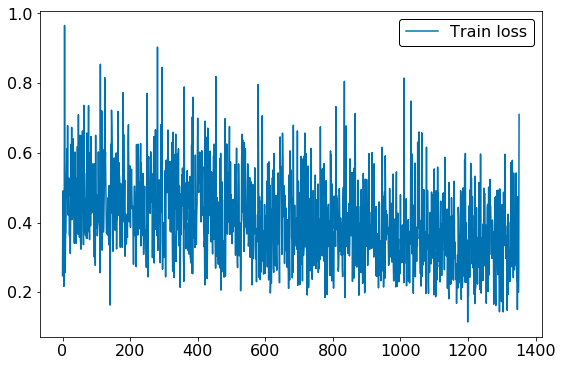

In [9]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.plot(losses,label='Train loss')
#plt.ylim([.4, .8])
plt.legend()
plt.show()

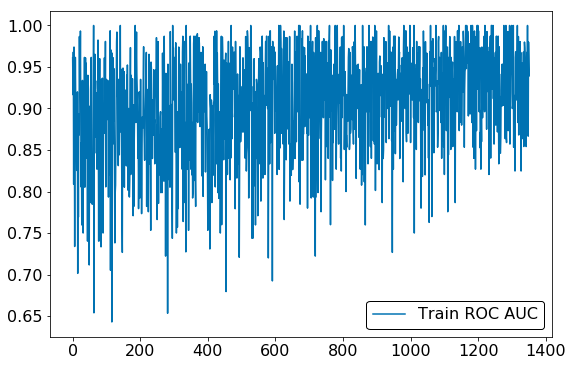

In [10]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.plot(train_roc, label = 'Train ROC AUC')
plt.legend()
plt.show()

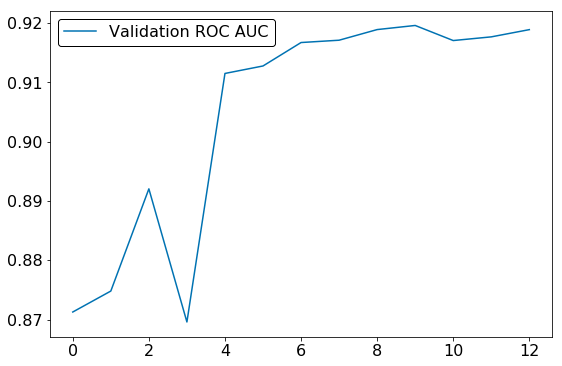

In [11]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.plot(val_roc, label = 'Validation ROC AUC')
plt.legend()
plt.show()


Baseline classification accuracy: 91.06

Model classification accuracy:    84.66


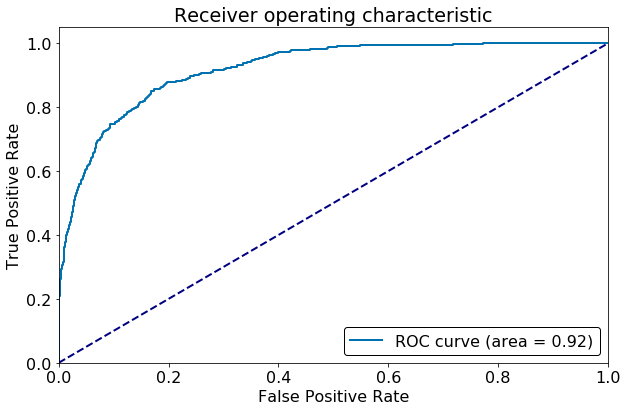

In [12]:
valid_predictions = []
valid_targets = []

model.eval() # prep model for evaluation
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        images = images.to(device)

        labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        valid_predictions += list(outputs.detach().cpu().numpy().ravel())
        valid_targets += list(labels.cpu().numpy().ravel()) 

fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
roc_auc = auc(fpr, tpr)

percent_tp = sum(valid_targets)/len(valid_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])
acc = 100 * np.sum(np.round(valid_predictions) == np.array(valid_targets)) / len(valid_targets)

print('\nBaseline classification accuracy: {:.2f}'.format(baseline))
print('\nModel classification accuracy:    {:.2f}'.format(acc))

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [13]:
tn, fp, fn, tp = confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel())).ravel()

accuracy = (tp + tn) / len(valid_targets)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("Model accuracy: {:.2f}".format(accuracy))
print("Model precision: {:.2f}".format(precision))
print("Model recall: {:.2f}".format(recall))

print("\nConfusion Matrix: ")
print(confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel())))

Model accuracy: 0.85
Model precision: 0.35
Model recall: 0.82

Confusion Matrix: 
[[4679  829]
 [  99  442]]


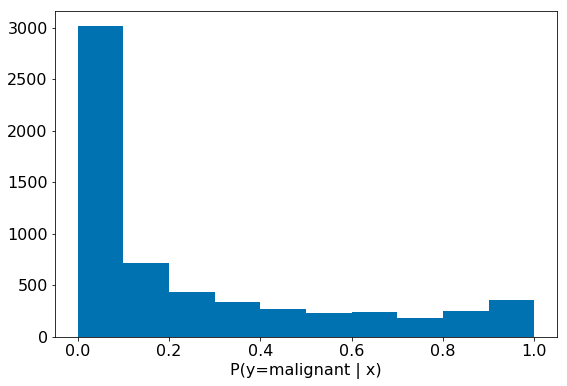

In [14]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.hist(valid_predictions)
plt.xlabel("P(y=malignant | x)")
plt.show()

In [15]:
#train_df.to_csv("ENET_train_df.csv", index=False)
#val_df.to_csv("ENET_val_df.csv", index=False)